In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from konlpy.tag import Okt
from konlpy.tag import Kkma

In [25]:
data = pd.read_csv('d:/data/project/data/review_data_naver.csv')
data = data.drop('Unnamed: 0.1', axis=1)
data = data.drop('Unnamed: 0', axis=1)
data

,movie,review,score
0,명량,여기에 말같잖은 평 다는 놈들은 매국노 인증인듯,10
1,명량,다좋았어요 한산보고나서 보니 더 좋네요,10
2,명량,"한국영화의 전성기 시절, 전무후무한 기록을 남겨준 영화.기대했던 것보다 더 잘 만들...",10
3,명량,2번째본 역사영화... 진짜 이순신은 대단한 영웅중에 영웅. 보는내내 끝까지 긴장놓...,10
4,명량,정말 거짓말 안한다.클레멘타인에 대한 평가를 호평으로 오해했으면 관객수가 이리 나왔...,1
...,...,...,...
49995,완득이,9.2/정말행복한영화.큰사건없이잔잔하게흘러가지만보면볼수록기분이좋아짐.더불어배우들연기...,9
49996,완득이,잔잔하게 빠져드는 영화...,10
49997,완득이,이런 영화 너무 좋아함~~,10
49998,완득이,유아인이 너무 좋아 s2s2,10


### 리뷰 길이 및 단어수 파악

In [26]:
plt.rc('font', family='NanumGothic') 

In [27]:
# 통계 나타내주는 함수
def summary_stats(*series, labels):
    summary = [s.describe() for s in series]
    
    return pd.concat(summary, axis=1, keys=labels)

# 통계 히스토그램, 상자그림 함수
def review_plots(*series, labels):
    nc = int(len(series))
    fig, ax = plt.subplots(nrows=2, ncols=nc, figsize=(10*nc/2, 10))
    
    for i in range(nc):
        ax[0, i].hist(series[i], bins=50)
        ax[0, i].set_title(f'{labels[i]} 히스토그램', size=15)
        
        ax[1, i].boxplot(series[i], vert=False)
        ax[1, i].set_title(f'{labels[i]} 상자그림', size=15)
        ax[1, i].set_xlabel(labels[i])
    
    return ax

In [28]:
review_len = data['review'].apply(len)
review_words = data['review'].apply(lambda x: len(x.split()))

### (1) 통계

In [29]:
summary_stats(review_len, review_words, labels=['리뷰 길이', '리뷰 당 단어 수'])

,리뷰 길이,리뷰 당 단어 수
count,50000.000000,50000.000000
mean,44.752220,10.206680
std,51.309135,11.749363
min,1.000000,1.000000
25%,17.000000,4.000000
50%,28.000000,7.000000
75%,53.000000,12.000000
max,998.000000,235.000000


### (2) 그래프

array([[<AxesSubplot: title={'center': '리뷰 길이 히스토그램'}>,
        <AxesSubplot: title={'center': '리뷰 당 단어 수 히스토그램'}>],
       [<AxesSubplot: title={'center': '리뷰 길이 상자그림'}, xlabel='리뷰 길이'>,
        <AxesSubplot: title={'center': '리뷰 당 단어 수 상자그림'}, xlabel='리뷰 당 단어 수'>]],
      dtype=object)

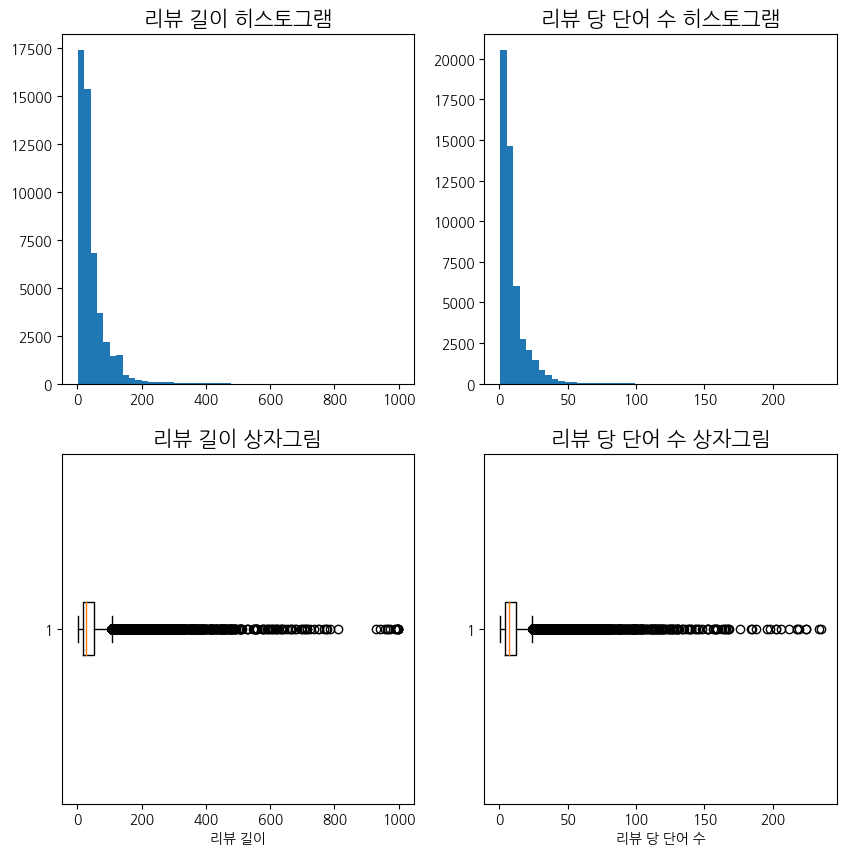

In [30]:
review_plots(review_len, review_words, labels=['리뷰 길이', '리뷰 당 단어 수'])

---

# 데이터 전처리 (Preprocessing)

- 데이터 분석과정을 바탕으로 데이터를 모델에 적용시키기 위해 전처리 과정을 진행한다.

In [31]:
import re
import json
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [32]:
data

,movie,review,score
0,명량,여기에 말같잖은 평 다는 놈들은 매국노 인증인듯,10
1,명량,다좋았어요 한산보고나서 보니 더 좋네요,10
2,명량,"한국영화의 전성기 시절, 전무후무한 기록을 남겨준 영화.기대했던 것보다 더 잘 만들...",10
3,명량,2번째본 역사영화... 진짜 이순신은 대단한 영웅중에 영웅. 보는내내 끝까지 긴장놓...,10
4,명량,정말 거짓말 안한다.클레멘타인에 대한 평가를 호평으로 오해했으면 관객수가 이리 나왔...,1
...,...,...,...
49995,완득이,9.2/정말행복한영화.큰사건없이잔잔하게흘러가지만보면볼수록기분이좋아짐.더불어배우들연기...,9
49996,완득이,잔잔하게 빠져드는 영화...,10
49997,완득이,이런 영화 너무 좋아함~~,10
49998,완득이,유아인이 너무 좋아 s2s2,10


In [33]:
## 문장 하나를 가져오기
review = data['review'][0]
review

'여기에 말같잖은 평 다는 놈들은 매국노 인증인듯'

#### (1) 한글을 제외한 나머지는 모두 공백처리 - 정규표현식
* 구두점, 물음표, 따옴표 등등 사라짐

In [34]:
review_text = re.sub('[^ㄱ-ㅎ가-힣0-9]', ' ', review)      # 한글, 숫자 아닌것들은 공백으로 표시
review_text

'여기에 말같잖은 평 다는 놈들은 매국노 인증인듯'

#### (2) split 메소드로 단어 분리

In [35]:
words = review_text.split()    # 단어 리스트
print(words)

['여기에', '말같잖은', '평', '다는', '놈들은', '매국노', '인증인듯']


#### (3) 한글 불용어 데이터 가져옴 (stopwords-ko.txt)

In [36]:
stopwords_data = pd.read_table('d:/data/project/data/stopwords-ko.txt')
s_words = stopwords_data['가'].tolist()
len(s_words), s_words

(594,
 ['가까스로',
  '가령',
  '각',
  '각각',
  '각자',
  '각종',
  '갖고말하자면',
  '같다',
  '같이',
  '개의치않고',
  '거니와',
  '거바',
  '거의',
  '것',
  '것과 같이',
  '것들',
  '게다가',
  '게우다',
  '겨우',
  '견지에서',
  '결과에 이르다',
  '결국',
  '결론을 낼 수 있다',
  '겸사겸사',
  '고려하면',
  '고로',
  '곧',
  '공동으로',
  '과',
  '과연',
  '관계가 있다',
  '관계없이',
  '관련이 있다',
  '관하여',
  '관한',
  '관해서는',
  '구',
  '구체적으로',
  '구토하다',
  '그',
  '그들',
  '그때',
  '그래',
  '그래도',
  '그래서',
  '그러나',
  '그러니',
  '그러니까',
  '그러면',
  '그러므로',
  '그러한즉',
  '그런 까닭에',
  '그런데',
  '그런즉',
  '그럼',
  '그럼에도 불구하고',
  '그렇게 함으로써',
  '그렇지',
  '그렇지 않다면',
  '그렇지 않으면',
  '그렇지만',
  '그렇지않으면',
  '그리고',
  '그리하여',
  '그만이다',
  '그에 따르는',
  '그위에',
  '그저',
  '그중에서',
  '그치지 않다',
  '근거로',
  '근거하여',
  '기대여',
  '기점으로',
  '기준으로',
  '기타',
  '까닭으로',
  '까악',
  '까지',
  '까지 미치다',
  '까지도',
  '꽈당',
  '끙끙',
  '끼익',
  '나',
  '나머지는',
  '남들',
  '남짓',
  '너',
  '너희',
  '너희들',
  '네',
  '넷',
  '년',
  '논하지 않다',
  '놀라다',
  '누가 알겠는가',
  '누구',
  '다른',
  '다른 방면으로',
  '다만',
  '다섯',
  '다소',
  '다수',
  '다시 말하자면',
  '다시말하면',

#### (4) 불용어 제거

In [37]:
words = [w for w in words if not w in s_words]
print(len(words), words)

7 ['여기에', '말같잖은', '평', '다는', '놈들은', '매국노', '인증인듯']


#### (5) 단어 리스트를 다시 하나의 글로 합치기 (데이터 정제)

In [38]:
clean_review = ' '.join(words)
len(clean_review), clean_review

(26, '여기에 말같잖은 평 다는 놈들은 매국노 인증인듯')

#### (6) PyKoSpacing(올바르게 띄어쓰기 하기)

In [106]:
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to c:\users\win10\appdata\local\temp\pip-req-build-ci114w2o
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit 1f8d11c59ac93525432f164e4c237ece4e298691
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tensorflow-2.9.3-cp38-cp38-win_amd64.whl (444.1 MB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached tensorboard-2.9.1-py3-none-any.whl (5.8 MB)
  Created wheel for pykospacing: filename=pykospacing-0.5-py3-none-any.whl size=2268651 sha256=49e55bbb56944a58f180f20990821b93f167d83ac77b7534729211fcd6d5d6d4
  Stored in directory: C:\Users\WIN10\AppData\Local\Temp\pip-ephem-wheel-cache-4xp5mum6\wheels\79\a0\33\16f2cd03d21f76a663f5d69a0b96f0351335385349136fbd03
Successfully built pykospacing
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.15.0
    Unin

  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git 'C:\Users\WIN10\AppData\Local\Temp\pip-req-build-ci114w2o'
ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\WIN10\\anaconda3\\envs\\nlp_py38\\Lib\\site-packages\\~ensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [42]:
from pykospacing import Spacing

spacing = Spacing()

# 띄어쓰기 없애기
review = clean_review.replace(" ", "")

# 띄어쓰기 변환
new_review = spacing(review)
    
print(new_review)

1/1 [==============================] - 0s 30ms/step
여기에 말같잖은 평다는 놈들은 매국노 인증인 듯


In [41]:
clean_review

'여기에 말같잖은 평 다는 놈들은 매국노 인증인듯'

#### 위의 과정을 모두 통합

In [44]:
#################### 과정 정리 #############################
review = data['review'][11]
remove_stopwords = True    ## option
print("<before>\n", review)  

# 1. 한글, 숫자 아닌 특수문자들을 공백(" ")으로 바꾸기
review_text = re.sub("[^ㄱ-ㅎ가-힣0-9]", " ", review)

# 2. 공백단위로 텍스트를 나눠서 리스트로 만든다.
words = review_text.split() 

# 3. 불용어 데이터 가져오기
stopwords_data = pd.read_table('d:/data/project/data/stopwords-ko.txt')
s_words = stopwords_data['가'].tolist()

# 4. 불용어 제거 (불용어가 아닌 단어들로 이루어진 새로운 리스트 생성)
words = [w for w in words if not w in s_words]

# 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.
clean_review = ' '.join(words)

# 6. 올바른 띄어쓰기
spacing = Spacing()

# 띄어쓰기 없애기
review = clean_review.replace(" ", "")

# 띄어쓰기 변환
clean_review = spacing(review)

print('\n<after>\n', clean_review)

<before>
 사람들이 영화에 대한 평점이 아닌 이순신에 대한 평점을 매기는구나.. 국뽕에 눈 돌아가는것좀 자제했으면
1/1 [==============================] - 0s 23ms/step

<after>
 사람들이 영화에 대한 평점이 아닌 이순신에 대한 평점을 매기는구나 국뽕에 눈 돌아가는 것 좀 자제했으면


### 하나의 함수로 정의

In [64]:
#################### 함수 #############################
def preprocessing(review, remove_stopwords=True):  # 불용어 제거 : option  
    # 1. 한글, 숫자가 아닌 특수문자들을 공백(" ")으로 바꾸기
    review_text = re.sub("[^ㄱ-ㅎ가-힣0-9]", " ", review)

    # 2. 공백단위로 텍스트들 나눠서 리스트로 만든다.
    words = review_text.split()

    # 3. 불용어 데이터 가져오기
    stopwords_data = pd.read_table('d:/data/project/data/stopwords-ko.txt')
    s_words = stopwords_data['가'].tolist()
    
    # 4. 불용어들을 제거
    # 불용어가 아닌 단어들로 이루어진 새로운 리스트 생성 ????
    words = [w for w in words if not w in s_words]

    # 5. 단어 리스트를 공백을 넣어서 하나의 글로 합친다.
    clean_review = ' '.join(words)
    
    # 6. 올바른 띄어쓰기 만들기
    spacing = Spacing()
         
    # 띄어쓰기 없애기
    clean_review = clean_review.replace(" ", "")

    # 띄어쓰기 변환
    clean_review = spacing(clean_review)
            
    return clean_review

### 모든 리뷰에 전처리 함수 적용

In [69]:
data['review'][:5]

0                           여기에 말같잖은 평 다는 놈들은 매국노 인증인듯
1                                다좋았어요 한산보고나서 보니 더 좋네요
2    한국영화의 전성기 시절, 전무후무한 기록을 남겨준 영화.기대했던 것보다 더 잘 만들...
3    2번째본 역사영화... 진짜 이순신은 대단한 영웅중에 영웅. 보는내내 끝까지 긴장놓...
4    정말 거짓말 안한다.클레멘타인에 대한 평가를 호평으로 오해했으면 관객수가 이리 나왔...
Name: review, dtype: object

In [73]:
%%time
reviews = data['review']
clean_train_reviews = []
for review in reviews:
    clean_train_reviews.append(preprocessing(review, remove_stopwords = True))

# 전처리한 데이터 출력
clean_train_reviews[:10]

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


Exception ignored in: <function ScopedTFGraph.__del__ at 0x00000216FFA5F550>
Traceback (most recent call last):
  File "C:\Users\WIN10\anaconda3\envs\nlp_py38\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 55, in __del__
    self.deleter(self.graph)
AttributeError: deleter


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 22ms/step
CPU times: total: 1h 14min 1s
Wall time: 48min 41s


['여기에 말같잖은 평다는 놈들은 매국노 인증인 듯',
 '다 좋았어요 한산보고 나서 보니 더 좋네요',
 '한국영화의 전성기 시절 전무후무한 기록을 남겨준 영화 기대했던 것보다 더 잘 만들고 더 놀라움을 선사해줬던 영화',
 '2번째 본 역사영화 진짜 이순신은 대단한 영웅 중에 영웅보는 내내 끝까지 긴장 놓을 수 없고 이순신이란 인물이 정말 대단한 영웅임',
 '정말 거짓말 안 한다클레멘타인에 대한 평가를 호평으로 오해했으면 관객 수가 이리 나왔을 수도 있겠다는 생각이 들었다',
 '굳은 신념으로 살아온 장군보는 내내 눈물이 났습니다 그는 외로웠을까 요엄청나게 외롭고 서글펐던 인성과 지성 모두들 겸비했던 이순신 당대의 꿋꿋했던 위인들은 너무 불쌍해요',
 '재미있게 잘 봤습니다',
 '조선용 감하다',
 '그냥 너무 지루 자체',
 '오랜만에 해줘서 보는데 연기력이 미친 수준이라 눈물이 터지더라 분명 처음 볼 땐 안이랬는데 확실히 나이 들어보니까 더 느껴지네 연출력도 좋고 연기력도 좋고 명작이 맞다']

### 전처리 완료된 리뷰 텍스트로 정제된(clean) 데이터프레임 생성
- 정제된 리뷰데이터를 csv 파일로 저장하기 위해 만들었음!

In [74]:
clean_train_df = pd.DataFrame({'영화':data['movie'], '리뷰':clean_train_reviews, '평점':data['score']})
clean_train_df

,영화,리뷰,평점
0,명량,여기에 말같잖은 평다는 놈들은 매국노 인증인 듯,10
1,명량,다 좋았어요 한산보고 나서 보니 더 좋네요,10
2,명량,한국영화의 전성기 시절 전무후무한 기록을 남겨준 영화 기대했던 것보다 더 잘 만들고...,10
3,명량,2번째 본 역사영화 진짜 이순신은 대단한 영웅 중에 영웅보는 내내 끝까지 긴장 놓을...,10
4,명량,정말 거짓말 안 한다클레멘타인에 대한 평가를 호평으로 오해했으면 관객 수가 이리 나...,1
...,...,...,...
49995,완득이,92 정말 행복한 영화 큰 사건 없이 잔잔하게 흘러가지만 보면 볼수록 기분이 좋아짐...,9
49996,완득이,잔잔하게 빠져드는 영화,10
49997,완득이,영화 너무 좋아함,10
49998,완득이,유아인이 너무 22,10


In [75]:
# csv파일로 저장
clean_train_df.to_csv('d:/data/project/clean_data_naver.csv')

# Okt 형태소 분석기 사용

# 임베딩 (Embedding)

## Word2vec

### 토크나이징 (벡터화)
* tensorflow.keras.preprocessing.text 에서 가져온 Tokenizer 클래스 사용

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_reviews)   # 단어장
text_sequences = tokenizer.texts_to_sequences(clean_train_reviews)   # 문장을 벡터화
print(text_sequences[0])  # 첫번째 문장 벡터화

[2321, 19732, 1785, 9388, 2987, 3922, 19733]


### 새로운 텍스트 데이터를 벡터화 하기 위해서는...
(1) 데이터 정제 (소문자--> 불용어 제거, 구두점 제거 등등...)  
(2) 위에서 만든 tokenizer에 texts_to_sequences()에 넣어서 벡터화

### 단어 사전 (tokenizer.word_index)

In [23]:
tokenizer.word_index

{'영화': 1,
 '너무': 2,
 '진짜': 3,
 '정말': 4,
 '잘': 5,
 '더': 6,
 '그냥': 7,
 '다': 8,
 '다시': 9,
 '연기': 10,
 '보고': 11,
 '봐도': 12,
 '수': 13,
 '영화를': 14,
 '최고의': 15,
 '봤는데': 16,
 '영화가': 17,
 '영화는': 18,
 '본': 19,
 '스토리': 20,
 '재밌게': 21,
 '역시': 22,
 '최고': 23,
 '있는': 24,
 '이게': 25,
 '없는': 26,
 '이렇게': 27,
 'ㅋㅋ': 28,
 '많이': 29,
 '보는': 30,
 '지금': 31,
 '한': 32,
 '내': 33,
 '평점': 34,
 '꼭': 35,
 '볼': 36,
 '좋은': 37,
 '내가': 38,
 '안': 39,
 '없다': 40,
 '다시봐도': 41,
 '마지막': 42,
 '재밌다': 43,
 '가장': 44,
 '봤습니다': 45,
 '연출': 46,
 '하는': 47,
 '연기가': 48,
 '액션': 49,
 '모든': 50,
 '한국': 51,
 '보면': 52,
 '마블': 53,
 '영화관에서': 54,
 '만든': 55,
 'ㅋㅋㅋ': 56,
 '난': 57,
 '명작': 58,
 '중': 59,
 '말이': 60,
 '같은': 61,
 '이거': 62,
 '평점이': 63,
 '배우들': 64,
 '감사합니다': 65,
 '재밌어요': 66,
 '재미있게': 67,
 '솔직히': 68,
 '재밌음': 69,
 '제일': 70,
 '근데': 71,
 '이건': 72,
 '계속': 73,
 '인생': 74,
 '넘': 75,
 '감동': 76,
 '영화다': 77,
 '연기도': 78,
 '스토리가': 79,
 '오랜만에': 80,
 '좋고': 81,
 '영화입니다': 82,
 '배우들의': 83,
 '봤어요': 84,
 '재밌고': 85,
 '완전': 86,
 '연기는': 87,
 '할': 88,
 '영화의': 89,

In [24]:
# 학습된 총 단어 수
len(tokenizer.word_index)

120098

In [25]:
max(tokenizer.word_index.values())

120098

* 인덱스가 1부터 시작하므로 0번은 '\<PAD\>'라는 문자열로 채움

In [26]:
## '<PAD>'라는 key를 0으로 설정
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0    # 0번은 <PAD>로 지정
word_vocab["<PAD>"]

0

In [27]:
print('전체 단어 개수:', len(word_vocab))

전체 단어 개수: 120099


### 생성된 Vocabulary 정보를 딕셔너리 (data_configs)로 만들어서 json파일로 저장

In [31]:
data_configs = {}
data_configs['vocab_size'] = len(word_vocab)
data_configs['vocab'] = word_vocab
data_configs   # 단어사전

{'vocab_size': 120099,
 'vocab': {'영화': 1,
  '너무': 2,
  '진짜': 3,
  '정말': 4,
  '잘': 5,
  '더': 6,
  '그냥': 7,
  '다': 8,
  '다시': 9,
  '연기': 10,
  '보고': 11,
  '봐도': 12,
  '수': 13,
  '영화를': 14,
  '최고의': 15,
  '봤는데': 16,
  '영화가': 17,
  '영화는': 18,
  '본': 19,
  '스토리': 20,
  '재밌게': 21,
  '역시': 22,
  '최고': 23,
  '있는': 24,
  '이게': 25,
  '없는': 26,
  '이렇게': 27,
  'ㅋㅋ': 28,
  '많이': 29,
  '보는': 30,
  '지금': 31,
  '한': 32,
  '내': 33,
  '평점': 34,
  '꼭': 35,
  '볼': 36,
  '좋은': 37,
  '내가': 38,
  '안': 39,
  '없다': 40,
  '다시봐도': 41,
  '마지막': 42,
  '재밌다': 43,
  '가장': 44,
  '봤습니다': 45,
  '연출': 46,
  '하는': 47,
  '연기가': 48,
  '액션': 49,
  '모든': 50,
  '한국': 51,
  '보면': 52,
  '마블': 53,
  '영화관에서': 54,
  '만든': 55,
  'ㅋㅋㅋ': 56,
  '난': 57,
  '명작': 58,
  '중': 59,
  '말이': 60,
  '같은': 61,
  '이거': 62,
  '평점이': 63,
  '배우들': 64,
  '감사합니다': 65,
  '재밌어요': 66,
  '재미있게': 67,
  '솔직히': 68,
  '재밌음': 69,
  '제일': 70,
  '근데': 71,
  '이건': 72,
  '계속': 73,
  '인생': 74,
  '넘': 75,
  '감동': 76,
  '영화다': 77,
  '연기도': 78,
  '스토리가': 79,
  '오랜만에'

### 전처리 마지막 단계
* 각 리뷰 벡터의 길이를 통일
* 특정 길이를 최대 길이로 정하고
    * 더 긴 벡터의 경우 뒷부분을 자르고...
    * 짧은 데이터의 경우 빈 공간을 0으로 패딩

In [34]:
train_word_counts

0         7
1         5
2        15
3        14
4        14
         ..
49995     9
49996     7
49997    18
49998     5
49999     4
Name: 리뷰, Length: 50000, dtype: int64

In [35]:
# 정제되지 않은 리뷰 문장을 split으로 분리한 리뷰당 단어 수의 중간값
np.median(train_word_counts)

7.0

In [36]:
# 정제된 리뷰 문장 기준 중간값
train_token_counts = np.array([len(vectorized_review) for vectorized_review in text_sequences])
np.median(train_token_counts)

6.0

In [37]:
## 리뷰당 단어 수의 중간값을 벡터의 최대 길이로 세팅
MAX_SEQUENCES_LENGTH = 7  # np.median(train_word_counts) = 174

In [40]:
## PADDING (keras에서 가져온 pad_sequences 활용)
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')   # 뒤쪽을 0으로 패딩
# train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='pre')      # 앞쪽을 0으로 패딩
train_inputs.shape, train_inputs

((50000, 7),
 array([[  2321,  19732,   1785, ...,   2987,   3922,  19733],
        [ 19734,  14347,     92, ...,    390,      0,      0],
        [     6,      5,    942, ...,   9389,  19735,      1],
        ...,
        [120096,      6,  10056, ...,   1206,    188,    465],
        [   243,   1358,   2605, ...,      0,      0,      0],
        [   901, 120098,   9245, ...,      0,      0,      0]]))

In [41]:
## 벡터화된 리뷰 문장 확인
train_inputs[1]

array([19734, 14347,    92,     6,   390,     0,     0])

In [42]:
train_labels = train_data['sentiment'].to_numpy()
train_labels

array(['긍정', '긍정', '긍정', ..., '긍정', '중립', '중립'], dtype=object)

### 정제된 데이터 저장

In [49]:
DATA_IN_PATH = 'd:/data/project/'

In [51]:
# 저장할 파일 이름 정의
# TRAIN_INPUT_DATA = 'train_input.npy'  # 벡터화된 데이터 : numpy array를 binary로 저장
# TRAIN_LABEL_DATA = 'train_label.npy'  # 정답 라벨 : numpy array를 binary로 저장
# TRAIN_CLEAN_DATA = 'train_clean.csv'  # 정제된 텍스트 데이터 : CSV 파일
# DATA_CONFIGS = 'data_configs.json'    # 데이터 정보(단어사전, 전체 단어 개수) : JSON 파일

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

In [52]:
## 전처리하여 벡터화된 데이터를 넘파이 형태로 저장 (binary file 형태)
np.save(open(DATA_IN_PATH + 'train_input.npy', 'wb'), train_inputs)  # 벡터화된 데이터 : numpy array를 binary로 저장
np.save(open(DATA_IN_PATH + 'train_label.npy', 'wb'), train_labels)  # 정답 라벨 : numpy array를 binary로 저장

In [53]:
# 정제된 텍스트를 csv 형태로 저장
clean_train_df.to_csv(DATA_IN_PATH + 'train_clean.csv')  # 정제된 텍스트 데이터 : CSV 파일
clean_train_df

,review,sentiment
0,여기에 말같잖은 평 다는 놈들은 매국노 인증인듯,긍정
1,다좋았어요 한산보고나서 보니 더 좋네요,긍정
2,한국영화의 전성기 시절 전무후무한 기록을 남겨준 영화 기대했던 것보다 더 잘 만들고...,긍정
3,2번째본 역사영화 진짜 이순신은 대단한 영웅중에 영웅 보는내내 끝까지 긴장놓을수없고...,긍정
4,정말 거짓말 안한다 클레멘타인에 대한 평가를 호평으로 오해했으면 관객수가 이리 나왔...,부정
...,...,...
49995,훈훈하고 괜찮은 영화 김윤석 너무 좋고 유아인도 아주 잘한다,긍정
49996,죽어가는 뻔한 스토리를 두 주연이 인공호흡 해놨다,중립
49997,김윤석의 연기 짱 툭툭 던지는 말투가 빵터지게 인간적이네요 전 유아인보다 김윤석씨가...,긍정
49998,유아인 일부러 찾아서 봤네요,중립


In [54]:
## 데이터 사전을 json형태로 저장
f = open(DATA_IN_PATH + 'data_configs.json', 'w')
json.dump(data_configs, f, ensure_ascii=False)
f.close()
# ensure_ascii가 True이면... ascii가 아닌 다른 문자들은 모두 이스케이프 문자(\)로 표현됨
# 반면, ensure_ascii를 False로 하면, Ascii에 포함되지 않는 문자들도 모두 출력
data_configs

{'vocab_size': 120099,
 'vocab': {'영화': 1,
  '너무': 2,
  '진짜': 3,
  '정말': 4,
  '잘': 5,
  '더': 6,
  '그냥': 7,
  '다': 8,
  '다시': 9,
  '연기': 10,
  '보고': 11,
  '봐도': 12,
  '수': 13,
  '영화를': 14,
  '최고의': 15,
  '봤는데': 16,
  '영화가': 17,
  '영화는': 18,
  '본': 19,
  '스토리': 20,
  '재밌게': 21,
  '역시': 22,
  '최고': 23,
  '있는': 24,
  '이게': 25,
  '없는': 26,
  '이렇게': 27,
  'ㅋㅋ': 28,
  '많이': 29,
  '보는': 30,
  '지금': 31,
  '한': 32,
  '내': 33,
  '평점': 34,
  '꼭': 35,
  '볼': 36,
  '좋은': 37,
  '내가': 38,
  '안': 39,
  '없다': 40,
  '다시봐도': 41,
  '마지막': 42,
  '재밌다': 43,
  '가장': 44,
  '봤습니다': 45,
  '연출': 46,
  '하는': 47,
  '연기가': 48,
  '액션': 49,
  '모든': 50,
  '한국': 51,
  '보면': 52,
  '마블': 53,
  '영화관에서': 54,
  '만든': 55,
  'ㅋㅋㅋ': 56,
  '난': 57,
  '명작': 58,
  '중': 59,
  '말이': 60,
  '같은': 61,
  '이거': 62,
  '평점이': 63,
  '배우들': 64,
  '감사합니다': 65,
  '재밌어요': 66,
  '재미있게': 67,
  '솔직히': 68,
  '재밌음': 69,
  '제일': 70,
  '근데': 71,
  '이건': 72,
  '계속': 73,
  '인생': 74,
  '넘': 75,
  '감동': 76,
  '영화다': 77,
  '연기도': 78,
  '스토리가': 79,
  '오랜만에'